In [1]:
import numpy as np
from scipy.interpolate import interp1d
import pylab as pl
from scipy.integrate import quad
%matplotlib inline

In [2]:
pl.rcParams['figure.figsize']  = 12, 7.5
pl.rcParams['lines.linewidth'] = 1.5
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 20  
pl.rcParams['font.sans-serif'] = 'serif'
pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'medium'

pl.rcParams['xtick.major.size'] = 8     
pl.rcParams['xtick.minor.size'] = 4     
pl.rcParams['xtick.major.pad']  = 8     
pl.rcParams['xtick.minor.pad']  = 8     
pl.rcParams['xtick.color']      = 'k'     
pl.rcParams['xtick.labelsize']  = 'medium'
pl.rcParams['xtick.direction']  = 'in'    

pl.rcParams['ytick.major.size'] = 8     
pl.rcParams['ytick.minor.size'] = 4     
pl.rcParams['ytick.major.pad']  = 8     
pl.rcParams['ytick.minor.pad']  = 8     
pl.rcParams['ytick.color']      = 'k'     
pl.rcParams['ytick.labelsize']  = 'medium'
pl.rcParams['ytick.direction']  = 'in' 

In [3]:
# Setting velocity and spatial grid points
N_positions = 21
ghost_zones = 3
N_velocity  = 201

In [4]:
# Boundaries of domain
left_boundary  = 0
right_boundary = 1.0
length         = right_boundary - left_boundary

In [5]:
# Setting mass of the particle, boltzmann-constant
mass_particle      = 1.0
boltzmann_constant = 1.0

In [6]:
# Scattering time scale
tau   = 1.0
# Magnitude of maximum velocity
v_max = 10

In [7]:
# Time Parameters for the simulation:
dt         = 0.01 # Size of the time-step
final_time = 1.0
time       = np.arange(dt, final_time, dt)

In [8]:
# Setting up the temperature parameters for the simulations:
T_initial = 1.0

In [9]:
# Setting up of spatial and velocity grids:
x  = np.linspace(left_boundary, right_boundary, N_positions)
dx = x[1] - x[0]

In [10]:
# Obtaining the coordinates for the ghost-zones:
x_ghost_left  = np.linspace(-(ghost_zones)*dx + left_boundary, left_boundary - dx, ghost_zones)
x_ghost_right = np.linspace(right_boundary + dx, right_boundary + ghost_zones*dx , ghost_zones)

In [11]:
# Combining them to obtain the entire spatial grid
x  = np.concatenate([x_ghost_left, x, x_ghost_right])

In [12]:
# Obtaining the velocity grid
v  = np.linspace(-v_max, v_max, N_velocity)

In [13]:
# Conversion to allow for easy vectorization
x = x * np.ones([N_velocity , N_positions + 2*ghost_zones])
v = v * np.ones([N_positions + 2*ghost_zones, N_velocity])
v = np.transpose(v)

In [14]:
def calculate_density(f, v):
    deltav           = v[1, 0]-v[0, 0]
    value_of_density = np.sum(f, axis = 0)*deltav
    return(value_of_density)

In [15]:
def calculate_momentum(f, v):
    deltav            = v[1, 0]-v[0, 0]
    value_of_momentum = np.sum(f*v, axis = 0)*deltav
    return(value_of_momentum)

In [16]:
def calculate_temperature(f, v):
    deltav               = v[1, 0]-v[0, 0]
    value_of_temperature = np.sum(f*v**2, axis = 0)*deltav
    return(value_of_temperature)

In [17]:
def f_MB(x, v, f):
    n = calculate_density(f, v) * np.ones([N_velocity, N_positions + 2*ghost_zones])
    T = calculate_temperature(f, v) * np.ones([N_velocity, N_positions + 2*ghost_zones])
    f_MB = n*np.sqrt(mass_particle/(2*np.pi*boltzmann_constant*T))*\
             np.exp(-mass_particle*v**2/(2*boltzmann_constant*T))
    return(f_MB)

In [18]:
def f_interp(dt, x, v, f):
    x_new     = x - v*(dt)
    f_interp  = np.zeros([N_velocity, N_positions + 2*ghost_zones])

    for i in range(N_velocity):
        left_indices   = np.where(x_new[i, ghost_zones:-ghost_zones]<=left_boundary)[0]
        right_indices  = np.where(x_new[i, ghost_zones:-ghost_zones]>=right_boundary)[0]
        wall_indices   = np.concatenate([left_indices, right_indices])
        all_indices    = np.arange(N_positions)
        indices_domain = np.delete(all_indices, wall_indices)
        
        interpolated_function                     = interp1d(x[i, :], f[i, :], 'cubic')
        f_interp[i, ghost_zones + indices_domain] = interpolated_function(x_new[i, ghost_zones + indices_domain])
    
        # Implementation of periodic B.C's
        for j in left_indices:
            while(x_new[i, j + ghost_zones]<left_boundary):
                x_new[i, j + ghost_zones] = x_new[i, j + ghost_zones] + length

        for j in right_indices:
            while(x_new[i, j + ghost_zones]>right_boundary):
                x_new[i, j + ghost_zones] = x_new[i, j + ghost_zones] - length

        for j in left_indices:
            f_interp[i, j + ghost_zones] = interpolated_function(x_new[i, j + ghost_zones])

        for j in right_indices:
            f_interp[i, j + ghost_zones] = interpolated_function(x_new[i, j + ghost_zones])

    return f_interp

In [19]:
# Intializing the values for rho with a sinusoidal perturbation
X                                                          = np.zeros(N_positions + 2*ghost_zones)
X[ghost_zones:-ghost_zones]                                = np.linspace(0, 2*np.pi, N_positions)
Y                                                          = 0.1*np.sin(X) + 1
Y[:ghost_zones]                                            = Y[(N_positions - 1):(N_positions + ghost_zones - 1)]
Y[N_positions + ghost_zones:N_positions + 2 * ghost_zones] = Y[(ghost_zones + 1):(1 + 2*ghost_zones)]

rho_init = Y
rho_init = rho_init * np.ones([N_velocity , N_positions + 2*ghost_zones])

In [20]:
# Initializing the initial distribution function:
f_initial = rho_init * np.sqrt(mass_particle/(2*np.pi*boltzmann_constant*T_initial)) * \
                       np.exp(-mass_particle*v**2/(2*boltzmann_constant*T_initial))

In [21]:
# Initializing the value of f_current for running the simulation:
f_current = f_initial

In [22]:
# Declaring a variable which will store the maximum values of density:
rho_max = np.zeros(time.size)

In [23]:
for time_index, t0 in enumerate(time):
    print(np.sum(abs(calculate_momentum(f_current, v))))
    #print("Computing For Time Index = ", time_index)
    # print("Physical Time            = ", t0)

    # We shall split the Boltzmann-Equation and solve it:
    # In this step we are solving the collisionless equation
    fstar = f_interp(dt, x, v, f_current)
    fstar[:, :ghost_zones] = fstar[:, (N_positions - 1):(N_positions + ghost_zones - 1)]
    fstar[:, N_positions + ghost_zones:N_positions + 2 * ghost_zones] = fstar[:, (ghost_zones + 1):(1 + 2*ghost_zones)]

    # We turn off the term v(df/dx) for the following two steps
    #f0             = f_MB(x, v, fstar)
    #f_intermediate = fstar - (dt/2)*(fstar          - f0)/tau
    
    #f_intermediate[:, :ghost_zones] = f_intermediate[:, (N_positions - 1):(N_positions + ghost_zones - 1)]
    #f_intermediate[:, N_positions + ghost_zones:N_positions + 2 * ghost_zones] = f_intermediate[:, (ghost_zones + 1):(1 + 2*ghost_zones)]
    
    #f_new          = fstar - (dt)  *(f_intermediate - f0)/tau
    
    # Implementation of periodic B.C's:
    #f_new[:, :ghost_zones] = f_new[:, (N_positions - 1):(N_positions + ghost_zones - 1)]
    #f_new[:, N_positions + ghost_zones:N_positions + 2 * ghost_zones] = f_new[:, (ghost_zones + 1):(1 + 2*ghost_zones)]
    f_current = fstar
    rho_max[time_index] = np.max(abs(calculate_density(f_current, v)))

2.03789940014e-15
0.114896610227
0.228432464248
0.339277630119
0.44615489357
0.547864240483
0.643305248868
0.731496786996
0.811593544365
0.882899010981
0.944874640285
0.997145058214
1.03949930717
1.0718882376
1.09441827367
1.10734188178
1.11104515623
1.10603300424
1.09291245985
1.07237468283
1.04517620504
1.01211997287
0.974036703101
0.931767022878
0.886144804779
0.837982039643
0.78805551484
0.737095488324
0.685776471773
0.634710162379
0.584440494795
0.535440724443
0.488112402198
0.442786059421
0.399723391799
0.359120710429
0.32111341862
0.285781272084
0.253154187555
0.223218379041
0.195922620516
0.171184457476
0.148896215944
0.128930685039
0.111146376715
0.0953922930136
0.0815121559932
0.0693480780816
0.0587436702603
0.0495466021151
0.0416106412165
0.0347972095902
0.0289765023577
0.0240282182273
0.0198419536982
0.0163173129757
0.0133637840325
0.0109004283799
0.00885542826137
0.00716553049276
0.00577542131378
0.00463706164426
0.00370900723787
0.00295573357033
0.00234698098209
0.0018571

In [24]:
N  = 512
Nt = 100
dx = 1./N
i  = np.arange(0, N, 1)
x  = (i + 0.5)*dx
tFinal  = 1.
t  = np.linspace(0, tFinal, Nt)

amplitude   = 0.1
k           = 2*np.pi
theta0      = T_initial
rho0        = 1.0

def rhoInit(x):
    return rho0 + amplitude*np.sin(k*x)

def thetaInit(x):
    return theta0

thetaInit = np.vectorize(thetaInit)

In [25]:
def f0(v, x):    
    rho   = rhoInit(x)
    theta = thetaInit(x)
    
    m = 1.
    k = 1.
        
    return rho * (m/(2*np.pi*k*theta))**(1./2.) * np.exp(-m*v**2./(2.*k*theta))

def f(v, x, t):

    return f0(v, x - v*t)

def rhoIntegrand(v, x, t):

    integralMeasure = 1.0
    
    return integralMeasure * f(v, x, t)

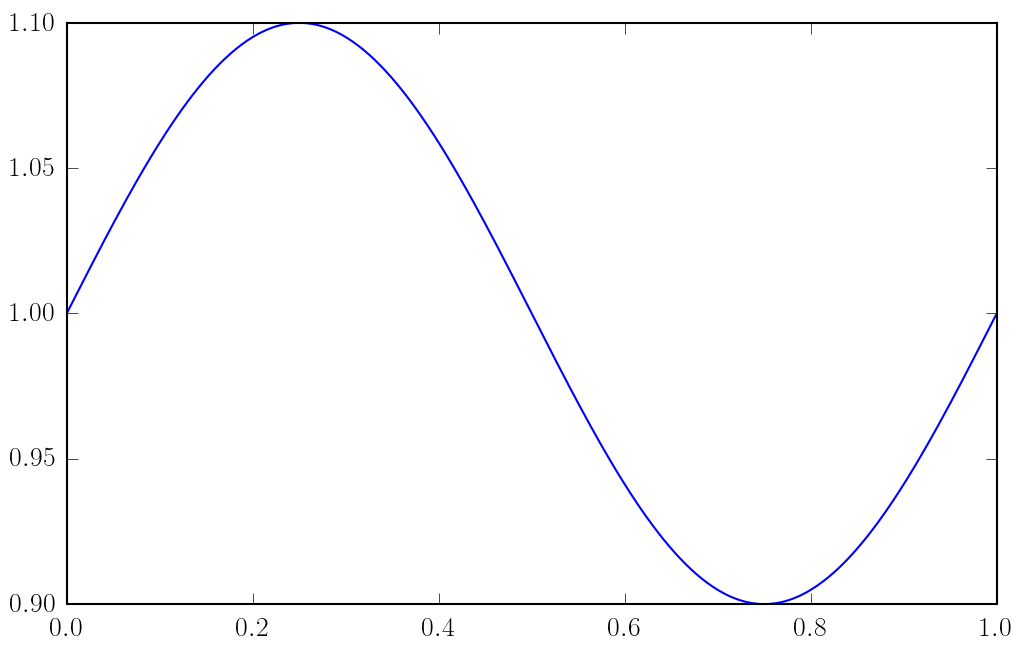

In [26]:
pl.plot(x, rhoInit(x))

In [27]:
gridPoint = N/4
solnVst = np.zeros(Nt)
for n in range(Nt):
    #print ("n = ", n)
    integral = quad(rhoIntegrand, -np.inf, np.inf, args=(x[gridPoint], t[n]))
    solnVst[n]  = integral[0]

/home/hyperion/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


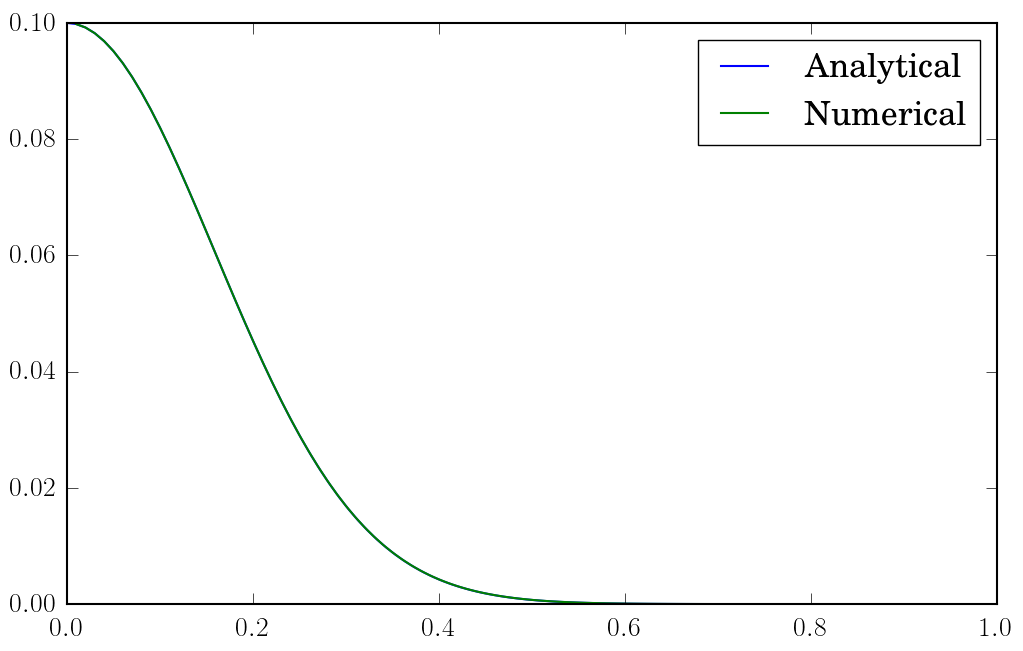

In [28]:
pl.plot(t, np.abs(solnVst - rho0), label='Analytical')
pl.plot(time, np.abs(rho_max - 1), label='Numerical')
pl.legend()